# DATA 604 Final Project
## Introduction to compartmental models of infectious disease outbreak
Jai Jeffryes

## Introduction
A compartmental model abstracts a system into categories representing states of interest and explores the transitions between states. A simple beginning for modeling an outbreak of infectious disease is to divide a population into three categories.

- Susceptible (S).
- Infected (I).
- Removed or Recovered (R).

See the accompanying processing flowcharts and stock-and-flow diagrams.

Additional categories or flows can appear in a model to represent various characteristics of diseases, like transmissability of infection or duration of immunity. For example, the dynamic of an incubation period preceding transmissibility of infection can be represented through addition of a compartment for Exposed (E) cases, thus an SEIR model, or the expiration of immunity can be represented by a flow returning to Susceptible, thus SIRS.

This project implements an SIR model of infectious disease transmission. Compartmental models such as the SIR model are deterministic. They emphasize average effects and work best in large populations where infection risks are fairly homogenous. [1]

The simplest SIR model is based on several assumptions, some of which include the following.

- Population is constant. It does not consider births and deaths.
- Immunity, once acquired upon recovery, endures forever.
- The population is well mixed. An individual has equal probability of contact with all other members of the population.

This project explores the assumption about mixing. Under normal circumstances, non-household daily contacts tend to exceed household contacts. Lockdown measures reduce non-household contacts to a level similar to or below household contacts. This project implements such a model and compares it to the simple SIR model.

First, we consider the simpler model. Then, we revisit the parameters and refine the transition equations to accommodate discrimination between household and non-household infections. [2]

- Sets
  - *t*: counts the time periods.
- Parameters
  - $\beta$. The average transmission rate between an infected individual and a susceptible one. In the first simple model, the assumption is that each contact results in transmission of infection. Therefore, $\beta$ equals the rate of contact.
  - $\gamma$. The average rate of recovery. It is the reciprocal of the duration of infection.
- Formulae. The SIR model is the following system of quadratic Ordinary Differential Equations. In our model, we measure proportions of the population, so the compartments for S and I are normalized by the population size $N$.
  - $\frac{dS}{dt} = -\frac{\beta S I}{N}$
  - $\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I$
  - $\frac{dR}{dt} = \gamma I$

## Initialize environment

In [1]:
from modsim import *

## Initialize system variables

In [2]:
def make_system(beta, gamma):
    init = State(S=49999, I=1, R=0)
    init /= sum(init)
    t0 = 0
    t_end = 100
    
    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

## Update state variables

In [3]:
def update_func(state, t, system):
    s, i, r = state
    infected = system.beta * i * s
    recovered = system.gamma * i
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

## Simulation function

In [4]:
################ RUN SIMULATION WITH TIME FRAME #####################
def run_simulation(system, update_func):
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init

    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)

    return frame

## Visualization function

In [5]:
def plot_results(S, I, R):
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(R, ':', label='Resistant')
    decorate(xlabel='Time (days)',
              ylabel='Fraction of population')

## Initialize variables

In [6]:
tc = 3                        # time between contacts in days
tr = 4.5                      # recovery time in days
#beta = 1 / tc                # contact rate per day
h_s = 2.7                     # Average household size. Discussed in next model.
c_c = 18                      # Contacts in the community. Discussed in next nodel.
beta = 0.05249 * (h_s + c_c)  # Assumptions for Dempsey's model of Ireland
                              # Transmission rate * (avg household size + community contacts)
gamma = 1 / tr                # Recovery rate per day

## Run simulation

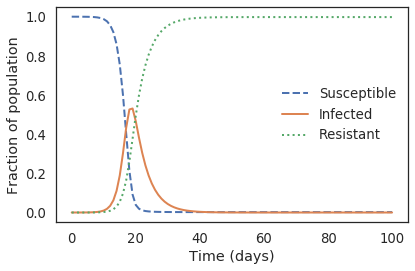

In [7]:
system = make_system(beta, gamma)
results = run_simulation(system, update_func)
plot_results(results.S, results.I, results.R)

## Early conclusions
- There is a threshold for infections. Historically, this was not evident until a model demonstrated it. [3]

## Refinement for household settings

We introduce new variables or redefine existing ones. First, a discussion of the definition of $\beta$, which governs the flow from the compartment of Susceptible to Infected.

Our simple SIR model defined $\beta$ as the contact rate. This assumes that each contact transmits infection. If we wish to consider probability of transmission, $\beta$ now represents transmissibility and we add to the ODEs a variable $\kappa$, representing average number of contacts.

- Parameters
  - $h_s$. Average household size.
  - $\beta_c$. The average transmission rate between an infected individual and a susceptible one in the community.
  - $\beta_h$. The average transmission rate between an infected individual and a susceptible one in a household setting. In this model we set the community and household transmission rates equal.
  - $\kappa$. Average number of contacts.
  - $C_c$. Cases who acquire infection via the community.
  - $C_h$. Cases who acquire infection via their household.
- Formulae
  - $\kappa - h_s + 1$. The number of non-household contacts.
  - $(h_s - 1) C_c$. The maximum number of household acquired infections in a population. This can be used as a carrying capacity on the growth rate of household infections. This project does not implement the carrying capacity of Dempsey's model does this.
  - ODEs
    - $\frac{dS}{dt} = -\beta \kappa I S$. Rate of change in susceptibility, still unadjusted for context of contact.
    - $\frac{dC_c}{dt} = \beta_c (k - h_s + 1) I S$. The rate of increase in community cases amongst the $(k - h_s + 1)$ non-household contacts.
    - $\frac{dC_h}{dt} = \beta_h (h_s - 1) I S (1 - \frac{C_h}{(h_s - 1) C_c})$. The rate of increase in household cases amongst $h_s - 1$ contacts and constrained by a carrying capacity.
    - $\frac{dS}{dt} = -\beta_c (k - h_s + 1) I S - \beta_h (h_s - 1) I S (1 - \frac{C_h}{(h_s - 1) C_c})$. The full ODE for rate of change for compartment S.

## Model with household contacts

## Initialize system variables

In [8]:
def make_system2(beta, kappa, gamma, h_s):
    init = State(S=49999, Cc=1, Ch=0, I=1, R=0)
    init /= sum(init)
    t0 = 0
    t_end = 100
    
    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, kappa=kappa, gamma=gamma, h_s=h_s)

## Update state variables

In [9]:
def update_func2(state, t, system):
    s, cc, ch, i, r = state
    
    # Infected
    # These don't work as separate compartments. Should they?
    cc += system.beta * (system.kappa - system.h_s + 1) * i * s                   #Community infections
    ch += system.beta * (system.h_s - 1) * i * s * (1 - (ch / ((h_s - 1) * cc)))  #Household infections
    
    # TO DO: Figure out how to make carrying capacity work.
    infected_c = system.beta * (system.kappa - system.h_s + 1) * i * s
    infected_h = system.beta * (system.h_s - 1) * i * s * 1 #(1 - (ch / ((h_s - 1) * cc)))

    recovered = system.gamma * i
    
    # These don't work if ch includes carrying capacity, which is self-referential.
    #s -= (cc + ch)              # subtract infected
    #i += (cc + ch) - recovered
    
    s -= infected_c + infected_h
    i += (infected_c + infected_h - recovered)
    r += recovered
    
    return State(S=s, Cc=cc, Ch=ch, I=i, R=r)

## Initialize variables

In [10]:
beta = 0.05249                # Transmission rate
kappa = 18                    # Contacts in the community
tr = 4.5                      # recovery time in days
gamma = 1 / tr                # Recovery rate per day
h_s = 2.7                     # Average household size. 

## Run simulation

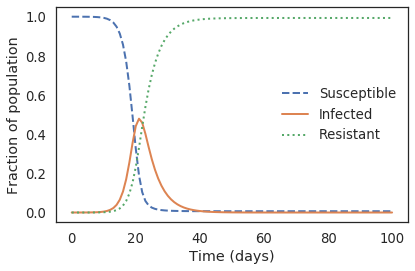

In [11]:
system2 = make_system2(beta, kappa, gamma, h_s)
results2 = run_simulation(system2, update_func2)
plot_results(results2.S, results2.I, results2.R)

## Compare infected curve
This simulation set an average household size lower than community contacts. There is some delay of peak infections and the maximum is slightly lower.

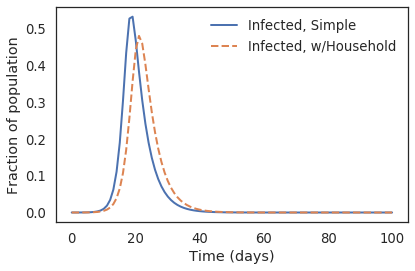

In [12]:
plot(results.I, '-', label='Infected, Simple')
plot(results2.I, '--', label='Infected, w/Household')
decorate(xlabel='Time (days)',
         ylabel='Fraction of population')

## Simulate lockdown
Next, we reduce total contacts while preserving household contacts.

## Initialize variables

In [13]:
beta = 0.05249                # Transmission rate
kappa = 10                    # REDUCE: Contacts in the community
tr = 4.5                      # recovery time in days
gamma = 1 / tr                # Recovery rate per day
h_s = 2.7                     # Average household size. 

## Run simulation

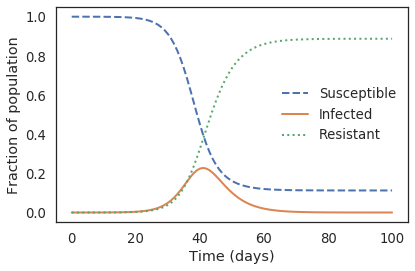

In [14]:
system3 = make_system2(beta, kappa, gamma, h_s)
results3 = run_simulation(system3, update_func2)
plot_results(results3.S, results3.I, results3.R)

## Compare infected curve
Compare the original simulation to the run with greatly reduced community contacts. The simulation demonstrates New York's policy of "flattening the curve."

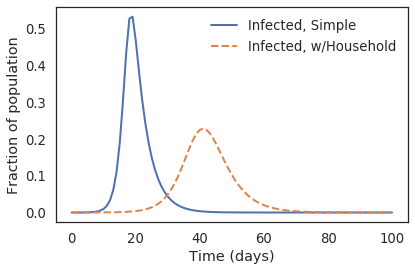

In [15]:
plot(results.I, '-', label='Infected, Simple')
plot(results3.I, '--', label='Infected, w/Household')
decorate(xlabel='Time (days)',
         ylabel='Fraction of population')

### To do
- Implement the carrying capacity of Dempsey's model.
- Interesting future work would include examination of the reproduction number, and
- Results of vaccination programs.

**Notes**
- Calculate $R_0$.
  - $R_0 = \frac{\beta S(0)}{\gamma}$
- Calculate critical immunization threshold.
  - $\beta (1 - q) \frac{S(0)}{\gamma} < 1 \iff q > 1 - \frac{1}{R_0}$
  - $P_c = 1 - \frac{1}{R_0}$
  - $\rho$. The fraction of susceptible individuals who get vaccinated and assuming the vaccine is 100% 

## References
  1. [PRISM Modeling Guidelines](http://prism.edu.au/wp-content/uploads/2016/09/PRISM_Modelling-guidelines-web.pdf).
  1. Paul Dempsey. [Modifying SEIR models to explore the role of average household size in the era of lockdowns and social distancing](https://osf.io/sa8jk/)
  1. Howard Weiss. [The SIR model and the foundations of public health](http://mat.uab.cat/web/matmat/wp-content/uploads/sites/23/2020/05/v2013n03.pdf).
  
## Acknowledgements
- Thanks to Paul Dempsey for discussions on LinkedIn about his SEIR paper.
- Thanks to Dr. Howard Weiss for correspondence and discussion about SIR models in public health policy and retrospective data collection and modeling issues during the 2020 pandemic crisis.
  
## Background
These materials assisted my exploration of infectious disease modeling and suggest further study.

 - [Compartmental models in epidemiology (Wikipedia)](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology).
 - [The SIR Model for spread of disease](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-introduction). Allen Downey's reference for his case study.
 - [NISS/ASA Tutorial on Susceptible-Infected-Recovered (SIR) Modeling](https://www.niss.org/events/nissasa-tutorial-susceptible-infected-recovered-sir-modeling). I missed the session, but this page has all the links to papers and a Shiny App. This is the most accessible model for starting out.
   - [NISS blog post](https://www.niss.org/news/susceptible-infected-recovered-sir-modeling-focus-nissasa-tutorial). This press release says a video of the session will be available on July 30th.
   - [Tutorial slides](https://www.niss.org/sites/default/files/SIR_Modeling_tutorial_ob.pdf).
   - [Code on GitHub](https://github.com/pnojai/posepi1).
   - [Shiny App](https://shiny.bcgsc.ca/posepi1/).
   - [The SIR model and the foundations of public health](http://mat.uab.cat/web/matmat/wp-content/uploads/sites/23/2020/05/v2013n03.pdf). Howard (Howie) Weiss. Very good orientation.
 - [Prism site](http://prism.edu.au). PRISM, the Centre for Research Excellence in Policy Relevant Infectious diseases Simulation and Mathematical Modelling in Australia.
   - [A User's Guide to Infectious Disease Modeling](http://prism.edu.au/wp-content/uploads/2016/09/PRISM_Modelling-guidelines-web.pdf). This manual is an excellent domain orientation.
 - Paul Dempsey's modified SIR model, exploring household and non-household contributions to case count under lockdown.
   - [Modifying SEIR models to explore the role of average household size in the era of lockdowns and social distancing](https://osf.io/sa8jk/)
   - [Paul Dempsey's model](http://covid19.dazult.com/index.html).
 - [Modeling COVID-19 Spread vs Healthcare Capacity](https://alhill.shinyapps.io/COVID19seir/). Shiny App to predict COVID-19 cases by clinical outcome. Comes with a well-documented tutorial.
   - [Code on GitHub](https://github.com/alsnhll/SEIR_COVID19).
 - [Forecasting COVID-19](https://robjhyndman.com/hyndsight/forecasting-covid19/). Rob Hyndman's assessment of model challenges. Includes a comparison of compartmental and agent-based models.
 - [Social distancing and mobility reductions have reduced COVID-19 transmission in King County, WA](https://covid.idmod.org/data/Social_distancing_mobility_reductions_reduced_COVID_Seattle.pdf). The study estimates the reproductive number from case data. It employs a distinctive SEIR model and documents the equations.
 - [COVID-19: Modeling Distributions of Incubation and Recovery Times](https://blog.iseesystems.com/stella-ithink/covid-19-modeling-distributions-of-incubation-and-recovery-times/). Stock and flow diagrams. Although the flows use inappropriate diagrammatic notation, they convey an idea. The article includes delays for state changes.
 - [Report 9: Impact of non-pharmaceutical interventions (NPIs) to reduce COVID-19 mortality and healthcare demand](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf). Neil Ferguson's analysis from March 2020.
